In [37]:
import os
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

In [38]:
# Function to get image paths and labels
def get_image_paths_and_labels(data_path):
    """Gathering image paths and labels with proper label encoding."""
    image_paths = []
    labels = []
    categories = sorted(os.listdir(data_path))  # Ensure consistent ordering
    
    for category in categories:
        category_path = os.path.join(data_path, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            if not images:
                print(f"Warning: No images found in {category_path}")
                continue  # Skip empty folders
            for img_name in images:
                img_path = os.path.join(category_path, img_name)
                image_paths.append(img_path)
                labels.append(category)
    
    print(f"Found {len(image_paths)} images across {len(categories)} categories.")
    
    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)  # Encodes labels into numbers
    return image_paths, labels, categories, label_encoder

In [39]:
# Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {img_path}, Error: {e}")
            return None  # Handle the error gracefully
        
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [ ]:
# VGGNet-19 class implementation
class VGG19(nn.Module):
    def __init__(self, num_classes=21, use_batch_norm=True, dropout_rate=0.5, pretrained=False):
        """
        Implementation of VGG-19 with configurable parameters.

        Args:
        - num_classes (int): Number of output classes.
        - use_batch_norm (bool): Whether to use BatchNorm.
        - dropout_rate (float): Dropout probability.
        - pretrained (bool): Whether to load pretrained weights.
        """
        super(VGG19, self).__init__()
        
        self.features = self._make_layers(use_batch_norm)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, num_classes)
        )
        
        # Load pretrained weights if specified
        if pretrained:
            self._load_pretrained_weights()

    def _make_layers(self, use_batch_norm):
        """
        Constructs the convolutional layers of VGG-19.
        """
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 
               512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
        
        layers = []
        in_channels = 3  # RGB input
        
        for x in cfg:
            if x == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layers.append(nn.Conv2d(in_channels, x, kernel_size=3, padding=1))
                if use_batch_norm:
                    layers.append(nn.BatchNorm2d(x))
                layers.append(nn.ReLU(inplace=True))
                in_channels = x
        
        return nn.Sequential(*layers)

    def _load_pretrained_weights(self):
        """
        Loads the pretrained VGG-19 weights from torchvision.
        """
        from torchvision.models import vgg19
        pretrained_vgg = vgg19(pretrained=True)
        self.features.load_state_dict(pretrained_vgg.features.state_dict())
        print("Pretrained VGG-19 weights loaded.")

    def forward(self, x):
        """
        Forward pass through the network.
        """
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [ ]:
# Training and testing functions

def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    """
    Trains the VGG-19 model.

    Args:
    - model (nn.Module): The VGG model.
    - train_loader (DataLoader): Training dataset loader.
    - criterion (loss function): Loss function (e.g., CrossEntropyLoss).
    - optimizer (torch.optim): Optimizer (e.g., Adam, SGD).
    - device (torch.device): Device (CPU/GPU).
    - epochs (int): Number of training epochs.
    """
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

def evaluate_model(model, test_loader, criterion, device, class_names):
    """
    Evaluates the VGG-19 model on the test dataset and prints the classification report and confusion matrix.

    Args:
    - model (nn.Module): The VGG model.
    - test_loader (DataLoader): Test dataset loader.
    - criterion (loss function): Loss function (e.g., CrossEntropyLoss).
    - device (torch.device): Device (CPU/GPU).
    - class_names (list): List of class names for labels.
    """
    model.eval()
    test_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Step1: Getting the image paths and labels...
Found 2100 images across 21 categories.
Step2: Splitting the images and labels into training and test datasets...
Step3: Initiating custom dataset class for both traing and testing dataset...
Step4: Initiating dataloader for both traing and testing dataset...
Step5: The VGG-19 model is being initiated...
Step6: Defining loss function and optimizer...
Step7: The model traing started...
Epoch [1/35], Loss: 3.1647, Accuracy: 8.84%
Epoch [2/35], Loss: 2.5755, Accuracy: 17.35%
Epoch [3/35], Loss: 2.1297, Accuracy: 31.22%
Epoch [4/35], Loss: 1.8038, Accuracy: 38.50%
Epoch [5/35], Loss: 1.6584, Accuracy: 45.85%
Epoch [6/35], Loss: 1.4848, Accuracy: 51.56%
Epoch [7/35], Loss: 1.2759, Accuracy: 56.12%
Epoch [8/35], Loss: 1.1287, Accuracy: 61.97%
Epoch [9/35], Loss: 0.9890, Accuracy: 66.39%
Epoch [10/35], Loss: 0.8664, Accuracy: 69.52%
Epoch [11/35], Loss: 0.7600, Accuracy: 73.67%
Epoch [12/35], Loss: 0.7395, Accuracy: 75.37%
Epoch [13/35], Loss: 0.67

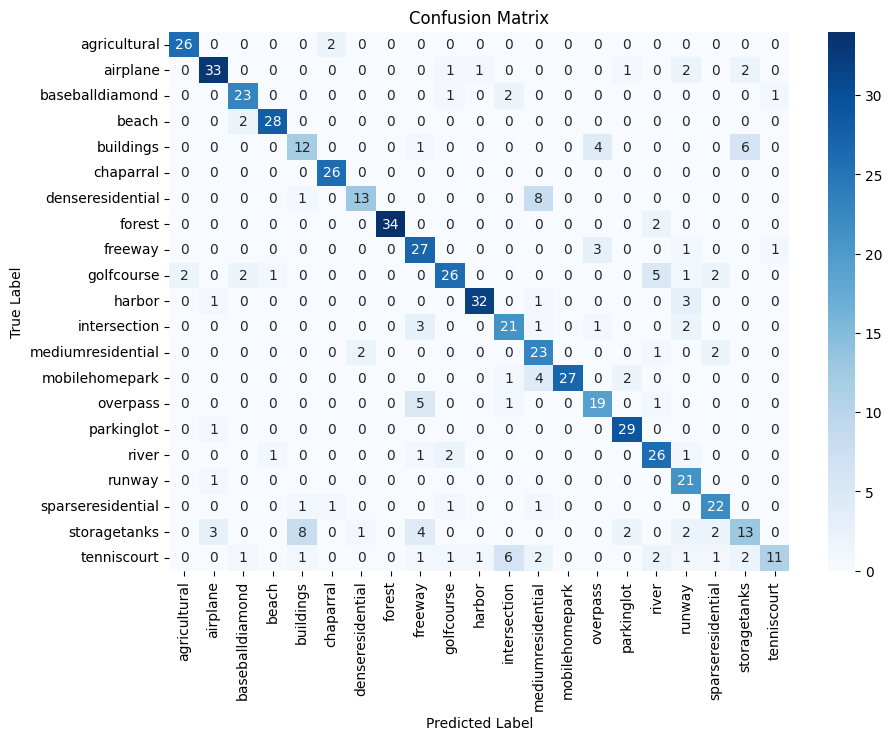

In [42]:
# Main execution

if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define transformations
    transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match VGG-19 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    data_path = r"C:\Users\debli\Downloads\UCMerced_LandUse\UCMerced_LandUse\Images"

    # Get image paths and labels
    print("Step1: Getting the image paths and labels...")
    image_paths, labels, categories, label_encoder = get_image_paths_and_labels(data_path)

    # Split data into training and test sets (70% train, 30% test)
    print("Step2: Splitting the images and labels into training and test datasets...")
    features_train, features_test, labels_train, labels_test = train_test_split(image_paths, labels, test_size=0.3, random_state=101)

    # Load dataset
    print("Step3: Initiating custom dataset class for both traing and testing dataset...")
    train_dataset = CustomImageDataset(features_train, labels_train, transform=transform)
    test_dataset = CustomImageDataset(features_test, labels_test, transform=transform)
    
    print("Step4: Initiating dataloader for both traing and testing dataset...")
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize model
    print("Step5: The VGG-19 model is being initiated...")
    model = VGG19(num_classes=21, use_batch_norm=True, dropout_rate=0.5, pretrained=False).to(device)

    # Define loss function & optimizer
    print("Step6: Defining loss function and optimizer...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Train and evaluate model
    print("Step7: The model traing started...")
    train_model(model, train_loader, criterion, optimizer, device, epochs=35)
    print("Step8: Model is being evaluated on the test dataset...")
    evaluate_model(model, test_loader, criterion, device, categories)
